## STEP 0: Downloading the dataset and install depencdencies

In [1]:
print("[*] Installing dependencies...")
!pip install lizard openai > /dev/null 2>&1
!pip install --upgrade transformers > /dev/null 2>&1
print("[*] Installation: DONE")
print("[*] Loading packages...")
import random, string, re, os, json, lizard, tempfile
from openai import OpenAI #opentrouter.ai
#import openai #Oritinal OpenAI
import pandas as pd
from collections import Counter
from tqdm import tqdm
from threading import Lock
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import numpy as np
print("[*] Load: DONE")
print("[*] Downloading LLM-AuthorBench dataset")
!wget -O LLM-AuthorBench.json.zip https://github.com/LLMauthorbench/LLMauthorbench/raw/main/LLM-AuthorBench.json.zip > /dev/null 2>&1
# Unzip the file
!unzip LLM-AuthorBench.json.zip > /dev/null 2>&1
# Delete the zip file
!rm LLM-AuthorBench.json.zip > /dev/null 2>&1
print("[*] Download: DONE")

[*] Installing dependencies...
[*] Installation: DONE
[*] Loading packages...
[*] Load: DONE
[*] Downloading LLM-AuthorBench dataset
[*] Download: DONE


## STEP 1: Preprocessing the dataset ( Read, tokenize, Remove comments)

In [3]:
# Read JSON data from file
with open('/content/LLM-AuthorBench.json', 'r') as file:
    data = json.load(file)

# Convert JSON data to DataFrame
balanced_df = pd.DataFrame(data)

#To ensure clarity in classification for machine learning purposes, let's remove C samples that duplicate. This way, we avoid confusion in the classification process.
balanced_df.drop_duplicates(subset=['c_code'], inplace=True)

model_counts = balanced_df['model_name'].value_counts()
print(model_counts)


model_name
claude-3.5-haiku                  4000
gpt-4o                            4000
gemini-2.5-flash-preview-05-20    4000
qwen-2.5-72b-instruct             4000
deepseek-chat                     4000
gpt-4.1                           4000
llama-3.3-70b-instruct            4000
gpt-4o-mini                       4000
Name: count, dtype: int64


## STEP 2: Train traditional ML algorithms for 5-class authorship attribution

[*] Precomputing full feature matrix...

[*] Evaluating sample size: 500
=== Results for sample size 500 ===
KNN             | Acc: 0.170 | Prec: 0.191 | Recall: 0.170 | F1: 0.173 | Time: 0.00s
Random Forest   | Acc: 0.580 | Prec: 0.570 | Recall: 0.580 | F1: 0.574 | Time: 1.07s
Bagging (DT)    | Acc: 0.560 | Prec: 0.579 | Recall: 0.560 | F1: 0.566 | Time: 0.19s
SVM (Linear)    | Acc: 0.350 | Prec: 0.357 | Recall: 0.350 | F1: 0.350 | Time: 0.02s
SVM (Kernel)    | Acc: 0.220 | Prec: 0.237 | Recall: 0.220 | F1: 0.225 | Time: 0.04s
Decision Tree   | Acc: 0.450 | Prec: 0.452 | Recall: 0.450 | F1: 0.442 | Time: 0.03s
XGBoost         | Acc: 0.550 | Prec: 0.580 | Recall: 0.550 | F1: 0.561 | Time: 1.55s

[*] Evaluating sample size: 3000
=== Results for sample size 3000 ===
KNN             | Acc: 0.430 | Prec: 0.452 | Recall: 0.430 | F1: 0.431 | Time: 0.00s
Random Forest   | Acc: 0.755 | Prec: 0.754 | Recall: 0.755 | F1: 0.753 | Time: 4.74s
Bagging (DT)    | Acc: 0.630 | Prec: 0.637 | Recall: 0.

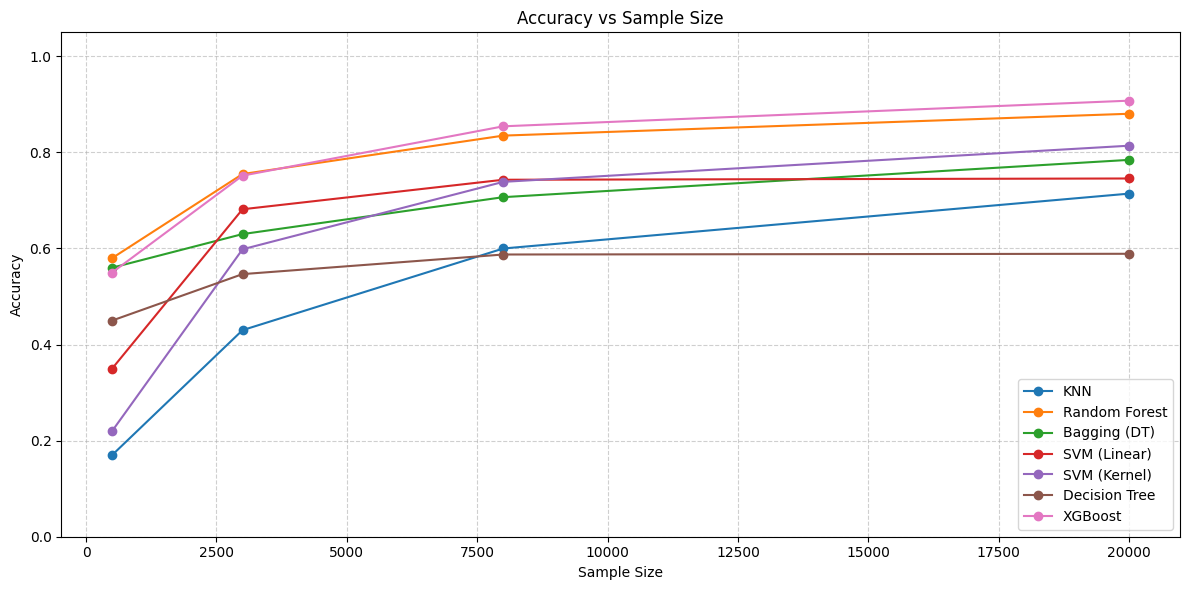

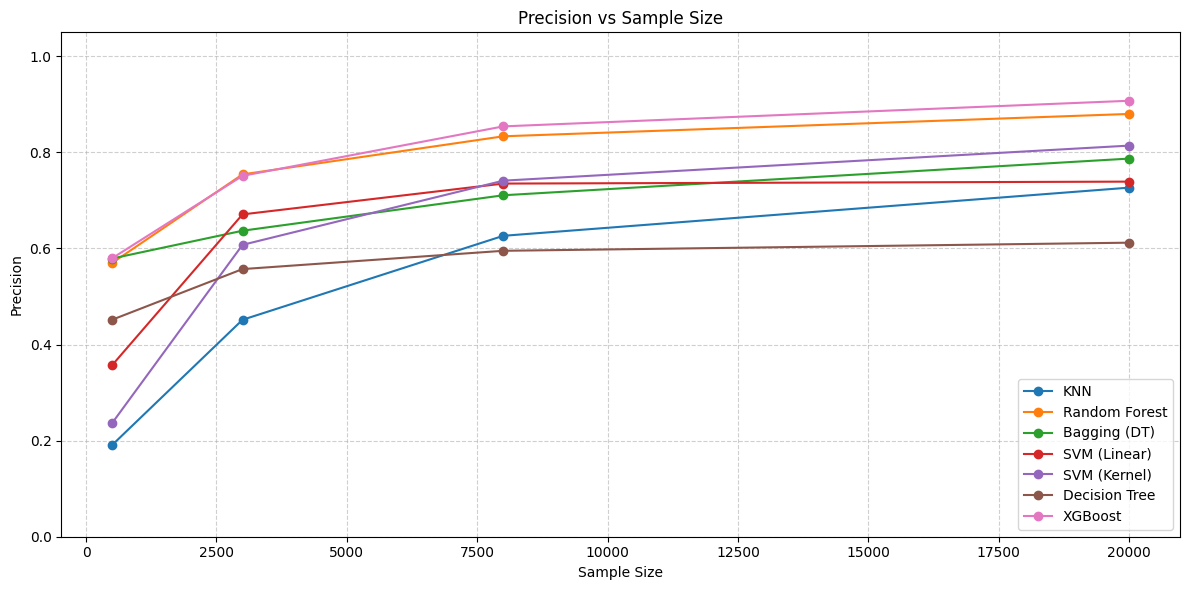

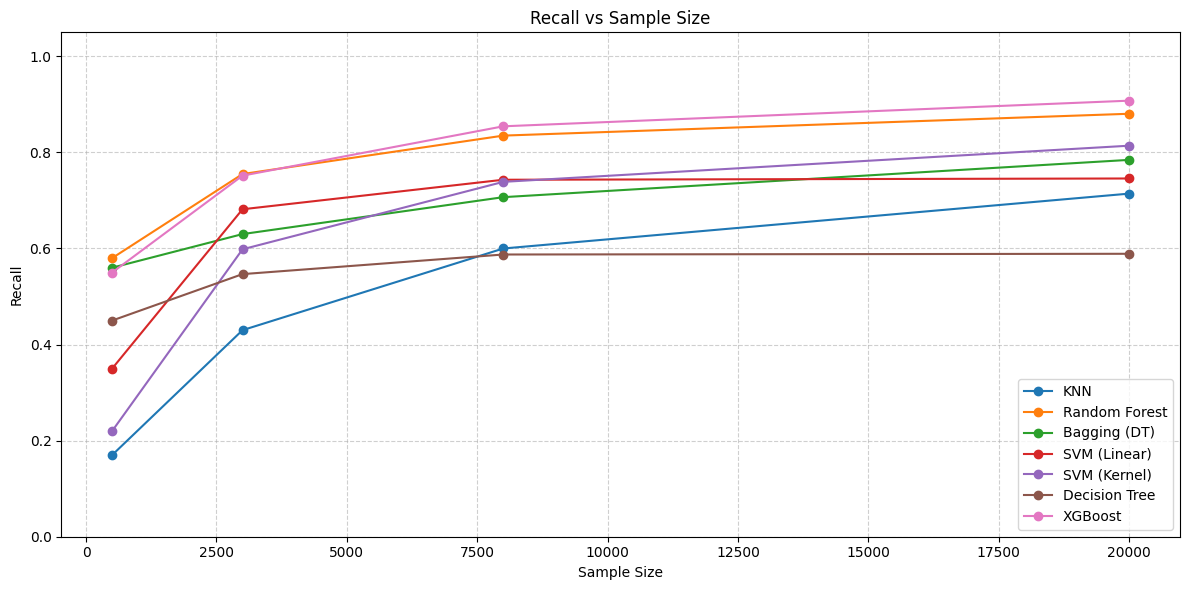

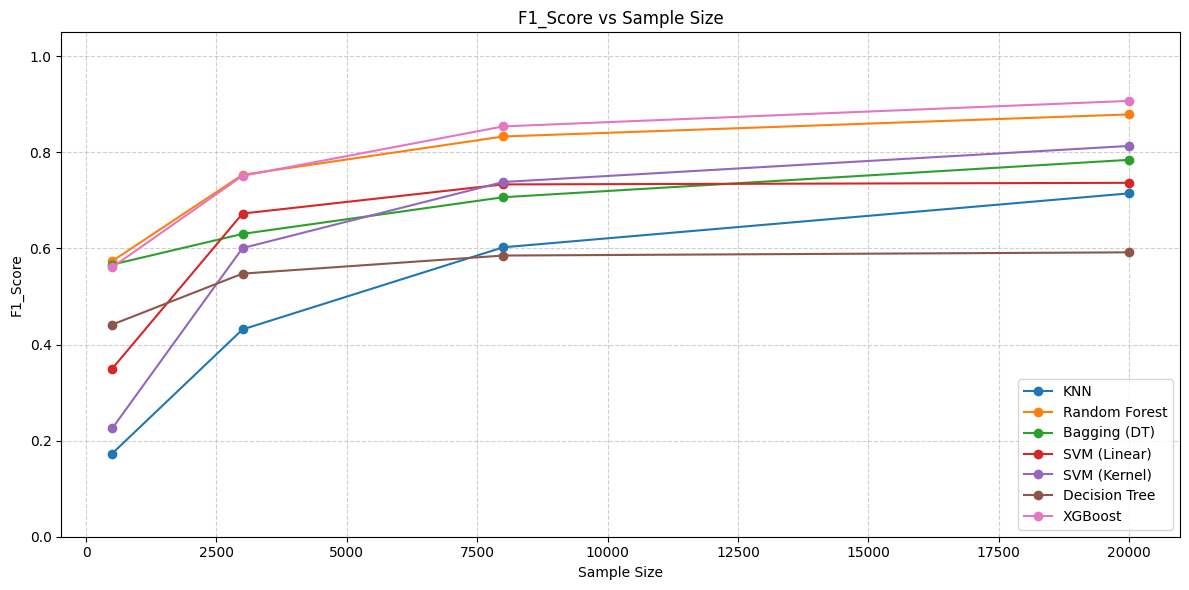

In [4]:
# ----------------------------- Imports -----------------------------
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    BaggingClassifier
)
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore")



# ----------------------------- Define Classifiers -----------------------------
def get_models():
    return {
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(n_estimators=400, random_state=42),
        'Bagging (DT)': BaggingClassifier(DecisionTreeClassifier(), random_state=42),
        'SVM (Linear)': LinearSVC(max_iter=2000, random_state=42),
        'SVM (Kernel)': SVC(kernel='rbf', random_state=42),
        'Decision Tree': DecisionTreeClassifier(max_depth=8, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=400, max_depth=9, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    }

# ----------------------------- Precompute Features ONCE -----------------------------

def prepare_features(df):
    # Use existing encoded labels
    tfidf_code = TfidfVectorizer(max_features=400, token_pattern=r"(?u)\b\w+\b")
    code_tfidf = tfidf_code.fit_transform(df['c_code'].fillna('')).toarray()
    X_full = code_tfidf # Only code. For other features one can add different numeric features
    y_full = df['label'].to_numpy()
    return X_full, y_full



# ----------------------------- Evaluate Different Sample Size -----------------------------
def evaluate_on_sample(X_full, y_full, sample_size, label_encoder):
    idx = np.random.RandomState(42).choice(len(X_full), size=sample_size, replace=False)
    X = X_full[idx]
    y = y_full[idx]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    models = get_models()
    metrics = {}

    for name, model in models.items():
        try:
            start_time = time.time()
            model.fit(X_train, y_train)
            elapsed = time.time() - start_time
            y_pred = model.predict(X_test)
            metrics[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
                'recall': recall_score(y_test, y_pred, average='weighted'),
                'f1_score': f1_score(y_test, y_pred, average='weighted'),
                'train_time_sec': elapsed
            }
        except Exception as e:
            print(f"❌ {name} failed on sample size {sample_size}: {e}")
    return metrics


# ----------------------------- Plotting -----------------------------
def plot_sample_size_results(all_results, metric):
    sample_sizes = sorted(all_results.keys())
    models = list(next(iter(all_results.values())).keys())

    plt.figure(figsize=(12, 6))
    for model in models:
        values = [all_results[size][model][metric] for size in sample_sizes]
        plt.plot(sample_sizes, values, marker='o', label=model)

    plt.title(f"{metric.title()} vs Sample Size")
    plt.xlabel("Sample Size")
    plt.ylabel(metric.title())
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# ----------------------------- Main Evaluation -----------------------------
def run_full_evaluation(df):
    print("[*] Precomputing full feature matrix...")
    X_full, y_full = prepare_features(df)

    sample_sizes = [500, 3000,8000,20000]
    all_results = {}

    for size in sample_sizes:
      print(f"\n[*] Evaluating sample size: {size}")
      metrics = evaluate_on_sample(X_full, y_full, size, None)
      all_results[size] = metrics

      print(f"=== Results for sample size {size} ===")
      for model_name, scores in metrics.items():
          acc = scores['accuracy']
          prec = scores['precision']
          rec = scores['recall']
          f1 = scores['f1_score']
          time_sec = scores['train_time_sec']
          print(f"{model_name:15s} | Acc: {acc:.3f} | Prec: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | Time: {time_sec:.2f}s")


    for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
        plot_sample_size_results(all_results, metric)

# ----------------------------- Run -----------------------------
# Step 1: Filter to just two LLMs and encode
encoder = LabelEncoder()

# Filter for only 'gpt-4.1' and 'gpt-4o' models
filtered_df = balanced_df[balanced_df['model_name'].isin(['gpt-4.1', 'deepseek-chat','claude-3.5-haiku','gemini-2.5-flash-preview-05-20','llama-3.3-70b-instruct'])].copy()
filtered_df['label'] = encoder.fit_transform(filtered_df['model_name'])
df = filtered_df

run_full_evaluation(df)


## STEP 3: Train only XGBOOST on 20k samples and show confusion Matrix

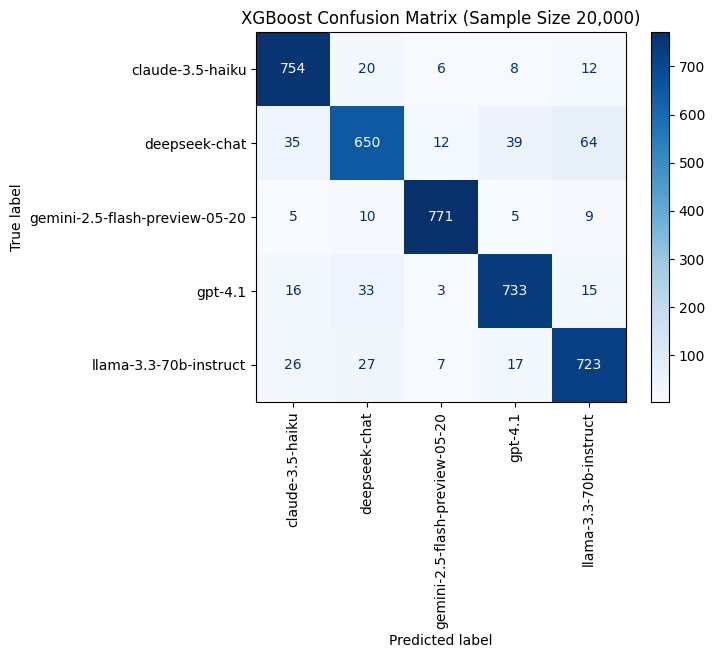

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prepare features and labels
X_full, y_full = prepare_features(df)

# Use the same seed/sample as your evaluation: sample_size=20000
sample_size = 20000
idx = np.random.RandomState(42).choice(len(X_full), size=sample_size, replace=False)
X = X_full[idx]
y = y_full[idx]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train XGBoost only
model = get_models()['XGBoost']
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("XGBoost Confusion Matrix (Sample Size 20,000)")
plt.show()
